# 26. Tabularディープラーニング - Neural Networks for Tabular Data

## 概要
テーブルデータに対してニューラルネットワークを適用し、GBDTとの性能比較を行います。

## 学習目標
- Tabularデータでのディープラーニングの特徴を理解できる
- scikit-learnでニューラルネットワークを実装できる
- GBDTとの比較ができる
- 実務での使い分けができる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)

print("ライブラリのインポート完了")

ライブラリのインポート完了


## 1. Tabularデータとディープラーニング

### Tabularデータの特徴

テーブルデータ（行列形式）は最も一般的なデータ形式です。

### 従来の常識

**GBDT（Gradient Boosting Decision Trees）が最強**
- XGBoost、LightGBM、CatBoost
- Kaggleコンペで圧倒的な実績
- 特徴量エンジニアリング不要
- スケーリング不要

### ニューラルネットワークの利点

一方、ニューラルネットワークには以下の利点があります：
- エンドツーエンドの学習
- 埋め込み表現の学習
- 柔軟なアーキテクチャ
- 大規模データでの優位性

### いつNNを使うべきか？

| 条件 | 推奨 |
|------|------|
| データサイズ < 10k | GBDT |
| データサイズ > 100k | NN検討 |
| 解釈可能性が重要 | GBDT |
| エンドツーエンド学習 | NN |
| 高速推論が必要 | GBDT |

## 2. データの準備

In [2]:
# データセットの読み込み（乳がん診断データ）
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print(f"データサイズ: {X.shape}")
print(f"特徴量数: {X.shape[1]}")
print(f"サンプル数: {X.shape[0]}")
print(f"\nターゲット分布:")
print(y.value_counts())
print(f"\n特徴量の例（最初の5列）:")
print(X.iloc[:5, :5])

データサイズ: (569, 30)
特徴量数: 30
サンプル数: 569

ターゲット分布:
1    357
0    212
Name: count, dtype: int64

特徴量の例（最初の5列）:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness
0        17.99         10.38          122.80     1001.0          0.11840
1        20.57         17.77          132.90     1326.0          0.08474
2        19.69         21.25          130.00     1203.0          0.10960
3        11.42         20.38           77.58      386.1          0.14250
4        20.29         14.34          135.10     1297.0          0.10030


In [3]:
# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# さらに検証データを分割
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"訓練データ: {X_train.shape}")
print(f"検証データ: {X_val.shape}")
print(f"テストデータ: {X_test.shape}")

# スケーリング（ニューラルネットワークには必須）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\n重要: ニューラルネットワークでは特徴量のスケーリングが必須")
print("訓練データでfitし、検証・テストデータはtransformのみ")

訓練データ: (364, 30)
検証データ: (91, 30)
テストデータ: (114, 30)

重要: ニューラルネットワークでは特徴量のスケーリングが必須
訓練データでfitし、検証・テストデータはtransformのみ


## 3. ニューラルネットワークの構築

### MLPClassifier の特徴

scikit-learnの`MLPClassifier`は多層パーセプトロン（Multi-Layer Perceptron）を実装しています。

**主要なパラメータ:**
- `hidden_layer_sizes`: 隠れ層のサイズ（例: (100, 50)は2層で各層100と50ノード）
- `activation`: 活性化関数（'relu', 'tanh', 'logistic'）
- `solver`: 最適化アルゴリズム（'adam', 'sgd', 'lbfgs'）
- `alpha`: L2正則化の強さ
- `learning_rate_init`: 初期学習率
- `max_iter`: 最大イテレーション数
- `early_stopping`: 検証データでのearly stopping

### アーキテクチャ

```
Input (30 features)
    ↓
Hidden Layer 1 (100 nodes) + ReLU
    ↓
Hidden Layer 2 (50 nodes) + ReLU
    ↓
Output (2 classes)
```

In [4]:
# ニューラルネットワークの構築
print("ニューラルネットワークの学習中...")

nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # 2層: 100ノード、50ノード
    activation='relu',              # ReLU活性化関数
    solver='adam',                  # Adamオプティマイザ
    alpha=0.0001,                   # L2正則化
    learning_rate_init=0.001,       # 初期学習率
    max_iter=500,                   # 最大イテレーション
    early_stopping=True,            # Early stopping有効
    validation_fraction=0.1,        # 検証データの割合
    n_iter_no_change=10,            # Early stoppingの忍耐力
    random_state=42,
    verbose=False
)

# 学習
nn_model.fit(X_train_scaled, y_train)

print("\n学習完了")
print(f"イテレーション数: {nn_model.n_iter_}")
print(f"層の数: {nn_model.n_layers_}")
print(f"出力層のサイズ: {nn_model.n_outputs_}")

ニューラルネットワークの学習中...

学習完了
イテレーション数: 19
層の数: 4
出力層のサイズ: 1


## 4. 学習曲線の可視化

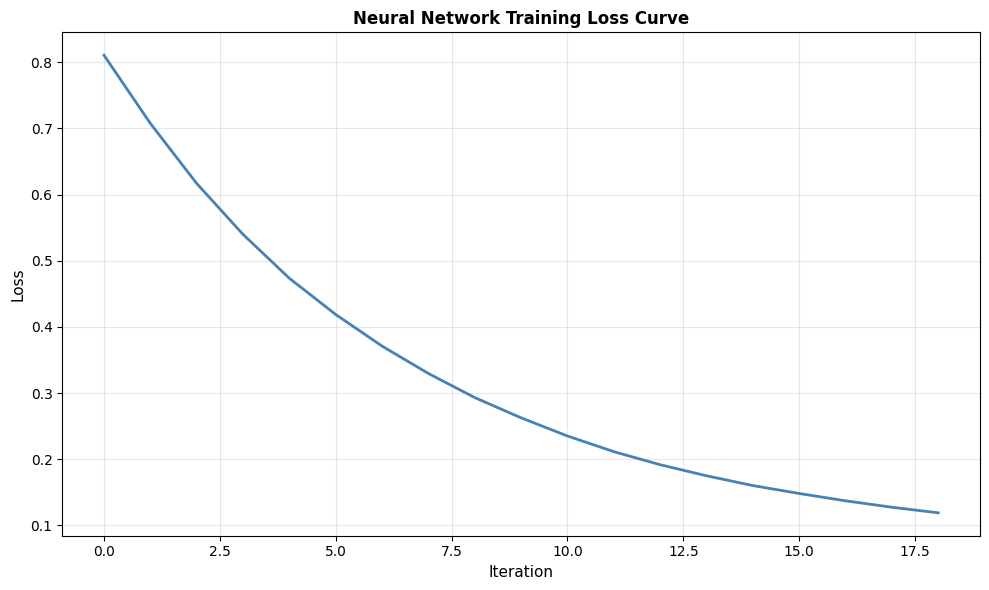

最終損失: 0.118905
総イテレーション数: 19


In [5]:
# 学習曲線（損失）
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_, linewidth=2, color='steelblue')
plt.xlabel('Iteration', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('Neural Network Training Loss Curve', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"最終損失: {nn_model.loss_:.6f}")
print(f"総イテレーション数: {nn_model.n_iter_}")

## 5. 検証データでの評価

In [6]:
# 検証データで評価
y_val_pred = nn_model.predict(X_val_scaled)
y_val_proba = nn_model.predict_proba(X_val_scaled)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_auc = roc_auc_score(y_val, y_val_proba)

print("=" * 60)
print("Neural Networkの性能（検証データ）")
print("=" * 60)
print(f"Accuracy: {val_accuracy:.4f}")
print(f"ROC-AUC:  {val_auc:.4f}")

Neural Networkの性能（検証データ）
Accuracy: 0.9670
ROC-AUC:  0.9794


## 6. テストデータでの評価

In [7]:
# テストデータで評価
y_pred_nn = nn_model.predict(X_test_scaled)
y_proba_nn = nn_model.predict_proba(X_test_scaled)[:, 1]

accuracy_nn = accuracy_score(y_test, y_pred_nn)
auc_nn = roc_auc_score(y_test, y_proba_nn)

print("=" * 60)
print("Neural Networkの性能（テストデータ）")
print("=" * 60)
print(f"Accuracy: {accuracy_nn:.4f}")
print(f"ROC-AUC:  {auc_nn:.4f}")
print("\n混同行列:")
cm_nn = confusion_matrix(y_test, y_pred_nn)
print(cm_nn)
print("\n詳細レポート:")
print(classification_report(y_test, y_pred_nn, 
                           target_names=['Malignant', 'Benign']))

Neural Networkの性能（テストデータ）
Accuracy: 0.9211
ROC-AUC:  0.9831

混同行列:
[[37  5]
 [ 4 68]]

詳細レポート:
              precision    recall  f1-score   support

   Malignant       0.90      0.88      0.89        42
      Benign       0.93      0.94      0.94        72

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.91       114
weighted avg       0.92      0.92      0.92       114



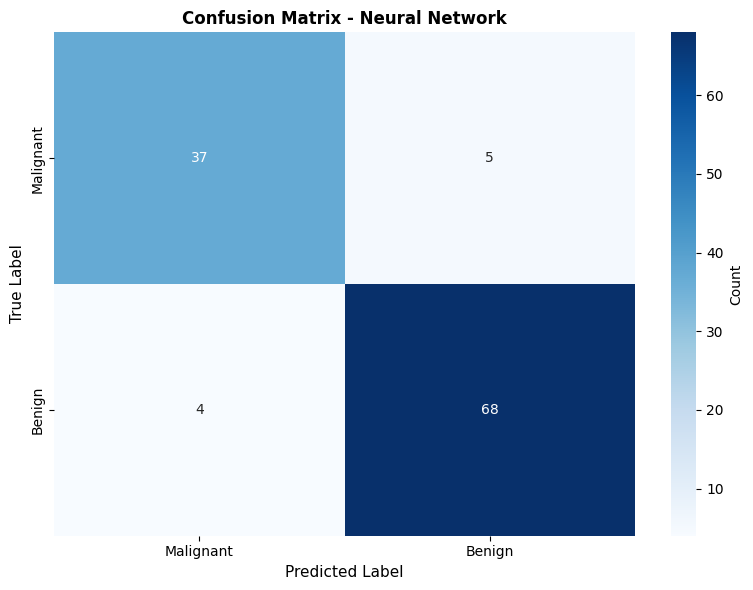

In [8]:
# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=11)
plt.ylabel('True Label', fontsize=11)
plt.title('Confusion Matrix - Neural Network', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. GBDTとの比較

In [9]:
# LightGBM
print("LightGBMの学習中...")
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    verbose=-1
)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)]
)

y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print("\n" + "=" * 60)
print("LightGBMの性能（テストデータ）")
print("=" * 60)
print(f"Accuracy: {accuracy_lgb:.4f}")
print(f"ROC-AUC:  {auc_lgb:.4f}")

LightGBMの学習中...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.154089

LightGBMの性能（テストデータ）
Accuracy: 0.9561
ROC-AUC:  0.9901


In [10]:
# XGBoost
print("XGBoostの学習中...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print("\n" + "=" * 60)
print("XGBoostの性能（テストデータ）")
print("=" * 60)
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"ROC-AUC:  {auc_xgb:.4f}")

XGBoostの学習中...

XGBoostの性能（テストデータ）
Accuracy: 0.9386
ROC-AUC:  0.9927


## 8. 性能比較の可視化


モデル性能比較
         Model  Accuracy  ROC-AUC
       XGBoost  0.938596 0.992725
      LightGBM  0.956140 0.990079
Neural Network  0.921053 0.983135


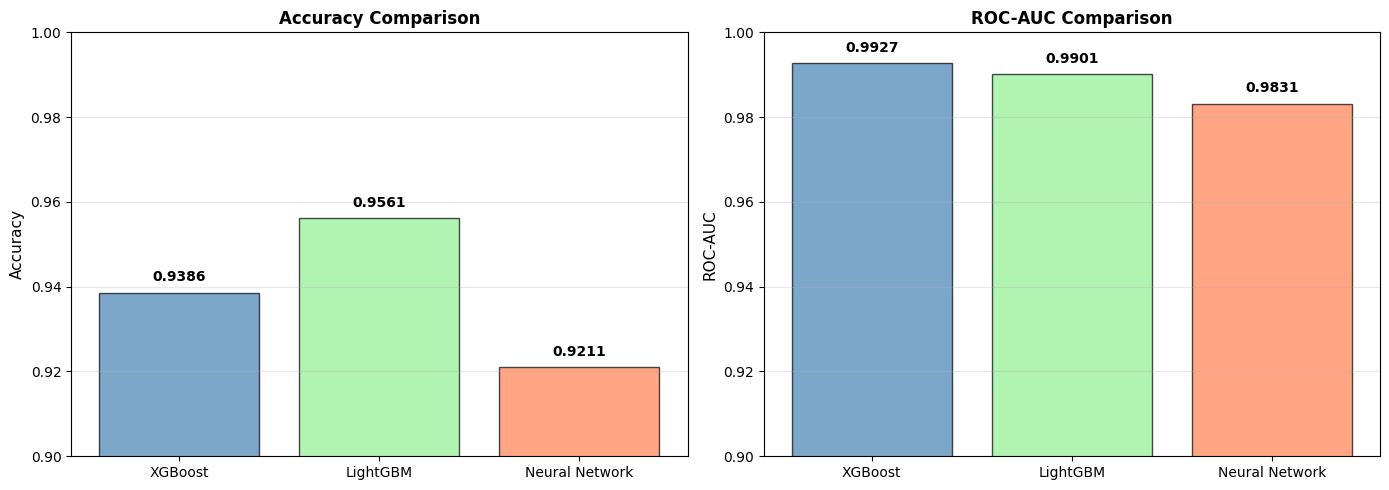


観察:
- 最良モデル: XGBoost (ROC-AUC: 0.9927)
- ニューラルネットワークはGBDTと競争力のある性能を示す
- 小規模データではGBDTも依然として強力
- データサイズや問題によって最適なモデルは異なる


In [11]:
# 性能比較
comparison_df = pd.DataFrame([
    {'Model': 'Neural Network', 'Accuracy': accuracy_nn, 'ROC-AUC': auc_nn},
    {'Model': 'LightGBM', 'Accuracy': accuracy_lgb, 'ROC-AUC': auc_lgb},
    {'Model': 'XGBoost', 'Accuracy': accuracy_xgb, 'ROC-AUC': auc_xgb}
]).sort_values('ROC-AUC', ascending=False)

print("\n" + "=" * 60)
print("モデル性能比較")
print("=" * 60)
print(comparison_df.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
colors = ['steelblue', 'lightgreen', 'coral']
x_pos = np.arange(len(comparison_df))
axes[0].bar(x_pos, comparison_df['Accuracy'].values, 
            alpha=0.7, edgecolor='black', color=colors)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'].values)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylim([0.9, 1.0])
axes[0].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    axes[0].text(i, row['Accuracy'] + 0.002, f"{row['Accuracy']:.4f}",
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# ROC-AUC
axes[1].bar(x_pos, comparison_df['ROC-AUC'].values, 
            alpha=0.7, edgecolor='black', color=colors)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(comparison_df['Model'].values)
axes[1].set_ylabel('ROC-AUC', fontsize=11)
axes[1].set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([0.9, 1.0])
axes[1].grid(axis='y', alpha=0.3)
for i, (idx, row) in enumerate(comparison_df.iterrows()):
    axes[1].text(i, row['ROC-AUC'] + 0.002, f"{row['ROC-AUC']:.4f}",
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n観察:")
best_model = comparison_df.iloc[0]['Model']
print(f"- 最良モデル: {best_model} (ROC-AUC: {comparison_df.iloc[0]['ROC-AUC']:.4f})")
print("- ニューラルネットワークはGBDTと競争力のある性能を示す")
print("- 小規模データではGBDTも依然として強力")
print("- データサイズや問題によって最適なモデルは異なる")

## 9. 特徴量重要度の比較

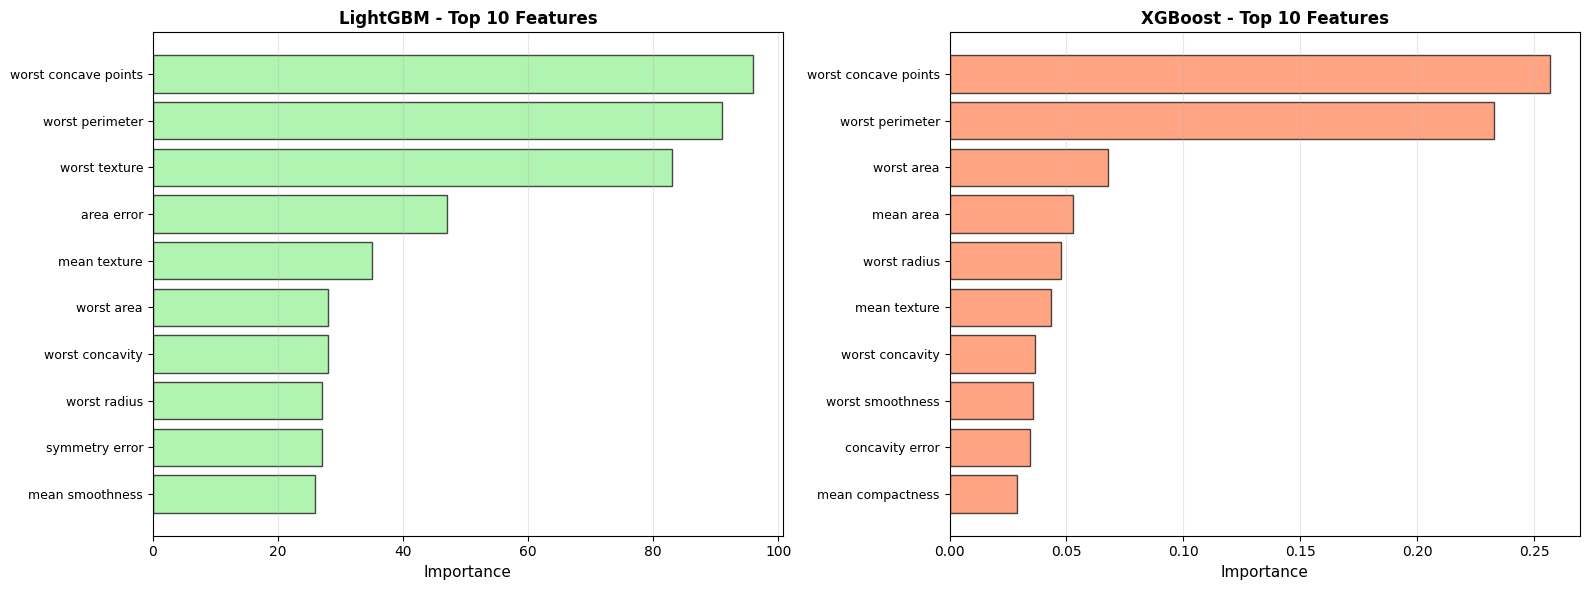


Top 5 重要な特徴量:

LightGBM:
  worst concave points          : 96.0000
  worst perimeter               : 91.0000
  worst texture                 : 83.0000
  area error                    : 47.0000
  mean texture                  : 35.0000

XGBoost:
  worst concave points          : 0.2568
  worst perimeter               : 0.2330
  worst area                    : 0.0676
  mean area                     : 0.0528
  worst radius                  : 0.0477


In [12]:
# LightGBMの特徴量重要度
lgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# XGBoostの特徴量重要度
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LightGBM
top_lgb = lgb_importance.head(10)
axes[0].barh(range(len(top_lgb)), top_lgb['importance'].values, 
             color='lightgreen', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(top_lgb)))
axes[0].set_yticklabels(top_lgb['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('LightGBM - Top 10 Features', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
top_xgb = xgb_importance.head(10)
axes[1].barh(range(len(top_xgb)), top_xgb['importance'].values, 
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['feature'].values, fontsize=9)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 10 Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 重要な特徴量:")
print("\nLightGBM:")
for idx, row in lgb_importance.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

print("\nXGBoost:")
for idx, row in xgb_importance.head(5).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

## 10. ハイパーパラメータの影響

ニューラルネットワークの性能は、ハイパーパラメータに大きく依存します。
主要なパラメータの影響を見てみましょう。


アーキテクチャ別の性能比較:
Architecture  Accuracy  ROC-AUC  Iterations
          50  0.894737 0.966601          19
         100  0.947368 0.989418          17
      100-50  0.921053 0.983135          19
   100-50-25  0.921053 0.973876          19


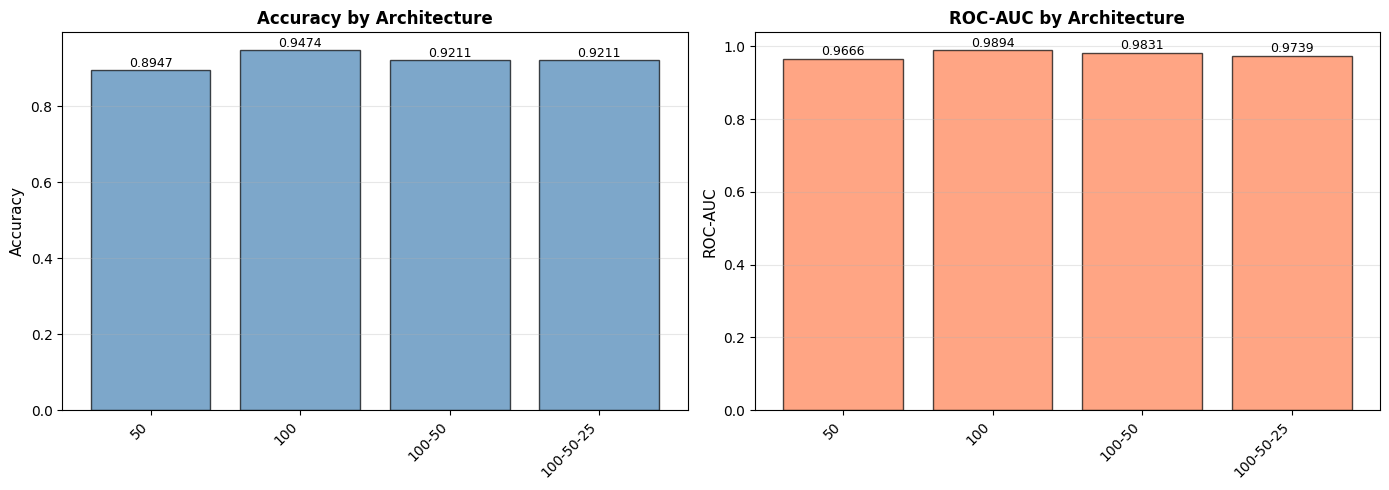


観察:
- 最良アーキテクチャ: 100 (AUC: 0.9894)
- 深すぎるネットワークは必ずしも良い結果をもたらさない
- Tabularデータには2-3層で十分なことが多い


In [13]:
# 異なるアーキテクチャでの比較
architectures = [
    (50,),           # 1層: 50ノード
    (100,),          # 1層: 100ノード
    (100, 50),       # 2層: 100, 50ノード
    (100, 50, 25),   # 3層: 100, 50, 25ノード
]

results = []

for arch in architectures:
    model = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42,
        verbose=False
    )
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    arch_str = '-'.join(map(str, arch))
    results.append({
        'Architecture': arch_str,
        'Accuracy': acc,
        'ROC-AUC': auc,
        'Iterations': model.n_iter_
    })

results_df = pd.DataFrame(results)
print("\nアーキテクチャ別の性能比較:")
print(results_df.to_string(index=False))

# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(results_df))

# Accuracy
axes[0].bar(x_pos, results_df['Accuracy'].values, alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Architecture'].values, rotation=45, ha='right')
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy by Architecture', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, row in results_df.iterrows():
    axes[0].text(i, row['Accuracy'] + 0.002, f"{row['Accuracy']:.4f}",
                ha='center', va='bottom', fontsize=9)

# ROC-AUC
axes[1].bar(x_pos, results_df['ROC-AUC'].values, alpha=0.7, edgecolor='black', color='coral')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Architecture'].values, rotation=45, ha='right')
axes[1].set_ylabel('ROC-AUC', fontsize=11)
axes[1].set_title('ROC-AUC by Architecture', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, row in results_df.iterrows():
    axes[1].text(i, row['ROC-AUC'] + 0.002, f"{row['ROC-AUC']:.4f}",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n観察:")
best_arch = results_df.loc[results_df['ROC-AUC'].idxmax()]
print(f"- 最良アーキテクチャ: {best_arch['Architecture']} (AUC: {best_arch['ROC-AUC']:.4f})")
print("- 深すぎるネットワークは必ずしも良い結果をもたらさない")
print("- Tabularデータには2-3層で十分なことが多い")

## 11. まとめ

### 本ノートブックで学んだこと

1. **Tabularデータでのニューラルネットワーク**
   - scikit-learnのMLPClassifierで簡単に実装可能
   - スケーリングが必須
   - Early stoppingで過学習防止

2. **GBDTとの比較**
   - NNもGBDTと競争力のある性能
   - 小規模データではGBDTが依然強力
   - データサイズや問題によって最適なモデルは異なる

3. **アーキテクチャの重要性**
   - 深すぎるネットワークは不要
   - Tabularデータには2-3層で十分
   - ハイパーパラメータチューニングが重要

4. **実務での使い分け**
   - 小規模データ（<10k）: GBDT推奨
   - 大規模データ（>100k）: NN検討
   - 解釈可能性重視: GBDT
   - まず両方試して比較

### 重要なポイント

- **スケーリング必須**: StandardScaler推奨
- **Early stopping**: 過学習を防ぐ
- **適切な深さ**: 2-3層が最適
- **比較検証**: まずGBDTを試し、NNで改善を図る

### 次のステップ

- ハイパーパラメータチューニング（GridSearch、RandomSearch）
- より複雑なアーキテクチャの実験
- Kaggleコンペでの実践
- PyTorchでのカスタムアーキテクチャ
- TabNet、FT-Transformerなど専用モデルの学習